In [4]:
#Libraries for data processing & statistics
#Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

#Import the module for the linear regression model
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

# Import module for statistical test
from scipy.stats import ttest_ind,levene,kruskal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.diagnostic import normal_ad

# cross validation using statsmodel prepartion
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, cross_validate, KFold

pd.set_option('display.max_columns', None)
plt.style.use('bmh')
sns.set()

pd.set_option('float_format', '{:f}'.format)

In [5]:
def print_coef_std_err(results):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param results: <statsmodels RegressionResultsWrapper> OLS regression results from statsmodel
    :return df: <pandas DataFrame> combined estimated coefficient and standard error of model estimate
    """
    coef = results.params
    std_err = results.bse
    
    df = pd.DataFrame(data = np.transpose([coef, std_err]), 
                      index = coef.index, 
                      columns=["coef","std err"])
    return df

In [6]:
# Import data
df = pd.read_csv('Sleep_Efficiency.csv')
df

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.000000,0.880000,18,70,12,0.000000,0.000000,0.000000,Yes,3.000000
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.000000,0.660000,19,28,53,3.000000,0.000000,3.000000,Yes,3.000000
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.000000,0.890000,20,70,10,1.000000,0.000000,0.000000,No,3.000000
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.000000,0.510000,23,25,52,3.000000,50.000000,5.000000,Yes,1.000000
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.000000,0.760000,27,55,18,3.000000,0.000000,3.000000,No,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,448,27,Female,2021-11-13 22:00:00,2021-11-13 05:30:00,7.500000,0.910000,22,57,21,0.000000,0.000000,0.000000,No,5.000000
448,449,52,Male,2021-03-31 21:00:00,2021-03-31 03:00:00,6.000000,0.740000,28,57,15,4.000000,25.000000,0.000000,No,3.000000
449,450,40,Female,2021-09-07 23:00:00,2021-09-07 07:30:00,8.500000,0.550000,20,32,48,1.000000,NaN,3.000000,Yes,0.000000
450,451,45,Male,2021-07-29 21:00:00,2021-07-29 04:00:00,7.000000,0.760000,18,72,10,3.000000,0.000000,0.000000,No,3.000000


In [7]:
#Check the data first
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      452 non-null    int64  
 1   Age                     452 non-null    int64  
 2   Gender                  452 non-null    object 
 3   Bedtime                 452 non-null    object 
 4   Wakeup time             452 non-null    object 
 5   Sleep duration          452 non-null    float64
 6   Sleep efficiency        452 non-null    float64
 7   REM sleep percentage    452 non-null    int64  
 8   Deep sleep percentage   452 non-null    int64  
 9   Light sleep percentage  452 non-null    int64  
 10  Awakenings              432 non-null    float64
 11  Caffeine consumption    427 non-null    float64
 12  Alcohol consumption     438 non-null    float64
 13  Smoking status          452 non-null    object 
 14  Exercise frequency      446 non-null    fl

Deskripsi variabel (yang kurang jelas):
1. **Sleep efficiency** : proporsi waktu yang dihabiskan untuk tidur saat seseorang berada di tempat tidur
2. **Awakenings** : Berapa kali seseorang terbangun di dalam durasi tidur
3. **Caffeine Consumption** : Konsumsi kafein selama 24 jam sebelum waktu tidur (dalam satuan mg)
4. **Alcohol Consumption** : Konsumsi alkohol selama 24 jam sebelum waktu tidur (dalam satuan ons)

Variabel target (outcome) yang dipakai adalah: **Sleep efficiency**


### **1. Define The Problems:**
- Variabel manakah pada data yang mempunyai pengaruh terhadap nilai Sleep Efficiency?
- Apakah variabel Gender mempunyai hubungan yang kuat dengan nilai Sleep Efficiency
- Apakah variabel Smoking status mempunyai hubungan yang kuat dengan nilai Sleep Efficiency?
- Selain Gender dan Smoking, variabel apa saja yang punya hubungan kuat dengan nilai Sleep Efficiency?
- Bagaimana kesimpulan akhirnya ? dan rekomendasi apakah yang dapat dilakukan?

#### **Data Cleaning & Preprocessing**

1. Check missing values and duplicate data

In [8]:
# check missing values, sorted
print("Missing values %:")
print(df.isna().sum().sort_values(ascending = False)/df.shape[0])

# Check duplicates
print("="*50)
print(f'Duplicate data: {df.duplicated().any()}')

Missing values %:
Caffeine consumption     0.055310
Awakenings               0.044248
Alcohol consumption      0.030973
Exercise frequency       0.013274
ID                       0.000000
Age                      0.000000
Gender                   0.000000
Bedtime                  0.000000
Wakeup time              0.000000
Sleep duration           0.000000
Sleep efficiency         0.000000
REM sleep percentage     0.000000
Deep sleep percentage    0.000000
Light sleep percentage   0.000000
Smoking status           0.000000
dtype: float64
Duplicate data: False


Terlihat ada 4 variabel yang memiliki beberapa missing data

In [9]:
df_new = df.dropna() # Untuk menghilangkan missing values pada data.
loss = 100 - (df_new.shape[0]/df.shape[0])*100 # Untuk menghitung persentase jumlah data yang hilang setelah dilakukan penghapusan data terduplikasi dan missing values.

print("Percentage data loss:")
print(f"{np.round(loss,3)} %")

Percentage data loss:
14.159 %


Karena data loss lebih mencapai lebih dari 10% jika dilakukan penghapusan missing values, maka akan dilakukan imputasi data dengan nilai statistik.  Sebelum pengisian missing values, akan dilakukan visualisasi setiap features untuk melihat distribusinya. Terdapat beberapa opsi statistik umum yang dapat digunakan untuk pengisian missing values, yaitu mean, median, dan modus

2. Fill missing data with imputation method

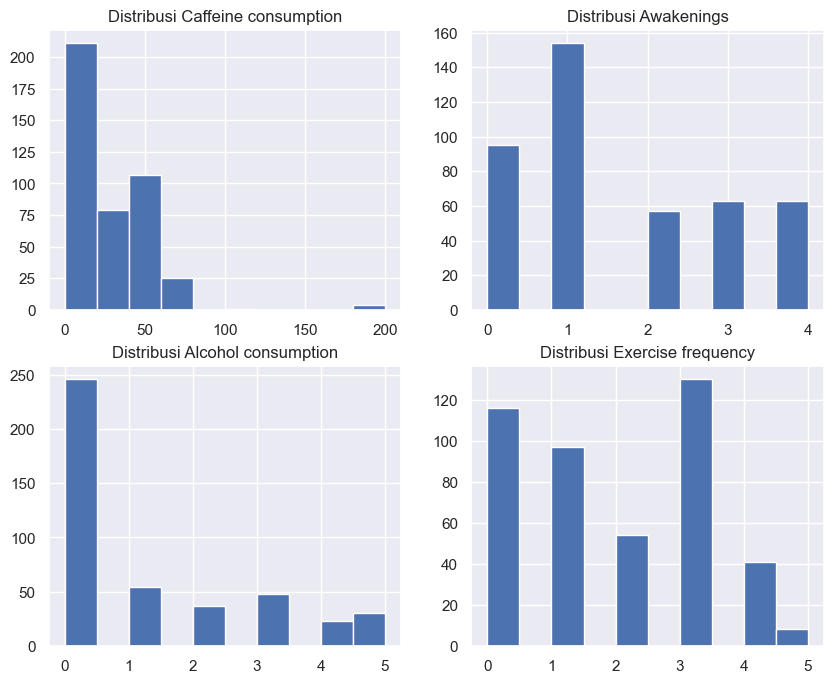

In [10]:
# Melihat distribusi setiap features.
columns_ = ["Caffeine consumption", "Awakenings", "Alcohol consumption", "Exercise frequency"]
index_ = 0
fig, ax = plt.subplots(2,2, figsize = (10,8)) # membuat figur dan axis untuk subplots
for row in range(2):
    for col in range(2):
        ax[row,col].hist(df[columns_[index_]])
        ax[row,col].set_title(f"Distribusi {columns_[index_]}")
        index_ += 1
plt.show()

In [12]:
# Menginput missing values dengan menggunakan statistik.
df["Caffeine consumption"] = df["Caffeine consumption"].fillna(value = df['Caffeine consumption'].median())
df["Alcohol consumption"] = df["Alcohol consumption"].fillna(value = df['Alcohol consumption'].median())
df["Awakenings"] = df["Awakenings"].fillna(value = df['Awakenings'].median())
df["Exercise frequency"] = df["Exercise frequency"].fillna(value = df['Exercise frequency'].median())

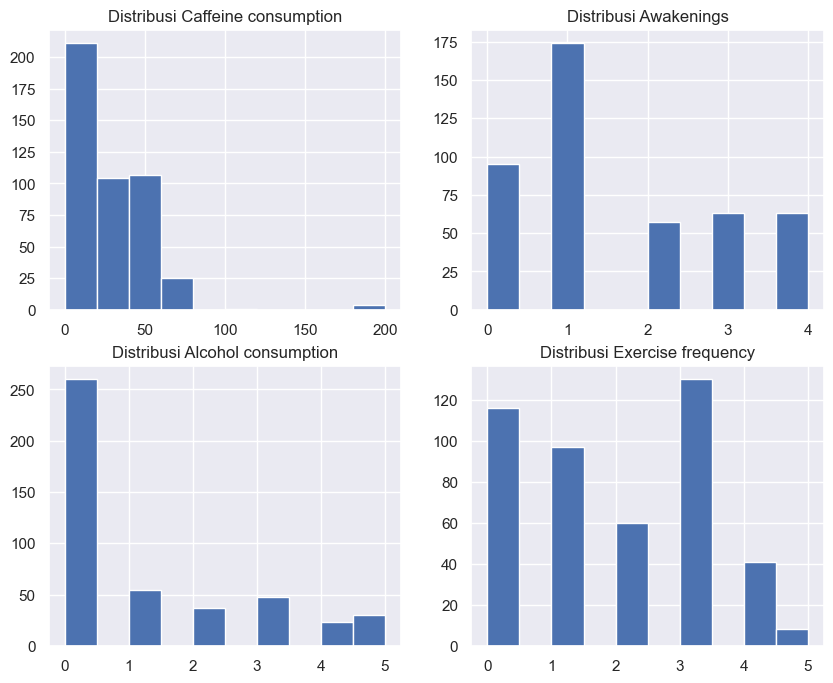

In [13]:
# Melihat kembali distribusi setiap features setelah imputasi data
columns_ = ["Caffeine consumption", "Awakenings", "Alcohol consumption", "Exercise frequency"]
index_ = 0
fig, ax = plt.subplots(2,2, figsize = (10,8)) # membuat figur dan axis untuk subplots
for row in range(2):
    for col in range(2):
        ax[row,col].hist(df[columns_[index_]])
        ax[row,col].set_title(f"Distribusi {columns_[index_]}")
        index_ += 1
plt.show()

In [14]:
print("Missing values proportion:")
print(df.isnull().sum()/df.shape[0])

Missing values proportion:
ID                       0.000000
Age                      0.000000
Gender                   0.000000
Bedtime                  0.000000
Wakeup time              0.000000
Sleep duration           0.000000
Sleep efficiency         0.000000
REM sleep percentage     0.000000
Deep sleep percentage    0.000000
Light sleep percentage   0.000000
Awakenings               0.000000
Caffeine consumption     0.000000
Alcohol consumption      0.000000
Smoking status           0.000000
Exercise frequency       0.000000
dtype: float64


2. Feature Engineering

Add new column for Early/Late bedtime category. Early if: 9-11 PM, if 12-2AM: Late

In [15]:
# Convert/parse bedtime & wakeup time to pandas datetime
df['Bedtime'] = pd.to_datetime(df['Bedtime'])
df['Wakeup time'] = pd.to_datetime(df['Wakeup time'])

# New column for bed/waking up hour
df['Bed_hour'] = df['Bedtime'].dt.hour
df['Wakeup_hour'] = df['Wakeup time'].dt.hour

In [16]:
#Remove date time columns
df.drop(['Bedtime','Wakeup time'], axis = 1, inplace = True)

In [51]:
#check values in Bed_hour
df["Bed_hour"].value_counts()

0     110
22     83
21     73
1      67
2      64
23     55
Name: Bed_hour, dtype: int64

Bedtime hour values in this dataset are only in the range of 9-2 AM 

In [17]:
# New column for bedtime category
# add duration category column
bed_status = [(df['Bed_hour'] >= 0) & (df['Bed_hour'] <=3) , (df['Bed_hour'] <= 23) & (df['Bed_hour'] >= 21)]
category = ["Late", "Early"]

df['Bed_status'] = np.select(bed_status, category)

In [18]:
# Check new data
df.head()

,ID,Age,Gender,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency,Bed_hour,Wakeup_hour,Bed_status
0,1,65,Female,6.000000,0.880000,18,70,12,0.000000,0.000000,0.000000,Yes,3.000000,1,7,Late
1,2,69,Male,7.000000,0.660000,19,28,53,3.000000,0.000000,3.000000,Yes,3.000000,2,9,Late
2,3,40,Female,8.000000,0.890000,20,70,10,1.000000,0.000000,0.000000,No,3.000000,21,5,Early
3,4,40,Female,6.000000,0.510000,23,25,52,3.000000,50.000000,5.000000,Yes,1.000000,2,8,Late
4,5,57,Male,8.000000,0.760000,27,55,18,3.000000,0.000000,3.000000,No,3.000000,1,9,Late


#### **Exploratory Data Analysis**

In [19]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,452.000000,226.500000,130.625419,1.000000,113.750000,226.500000,339.250000,452.000000
Age,452.000000,40.285398,13.172250,9.000000,29.000000,40.000000,52.000000,69.000000
Sleep duration,452.000000,7.465708,0.866625,5.000000,7.000000,7.500000,8.000000,10.000000
Sleep efficiency,452.000000,0.788916,0.135237,0.500000,0.697500,0.820000,0.900000,0.990000
REM sleep percentage,452.000000,22.615044,3.525963,15.000000,20.000000,22.000000,25.000000,30.000000
Deep sleep percentage,452.000000,52.823009,15.654235,18.000000,48.250000,58.000000,63.000000,75.000000
Light sleep percentage,452.000000,24.561947,15.313665,7.000000,15.000000,18.000000,32.500000,63.000000
Awakenings,452.000000,1.612832,1.332891,0.000000,1.000000,1.000000,3.000000,4.000000
Caffeine consumption,452.000000,23.727876,29.355363,0.000000,0.000000,25.000000,50.000000,200.000000
Alcohol consumption,452.000000,1.137168,1.608938,0.000000,0.000000,0.000000,2.000000,5.000000


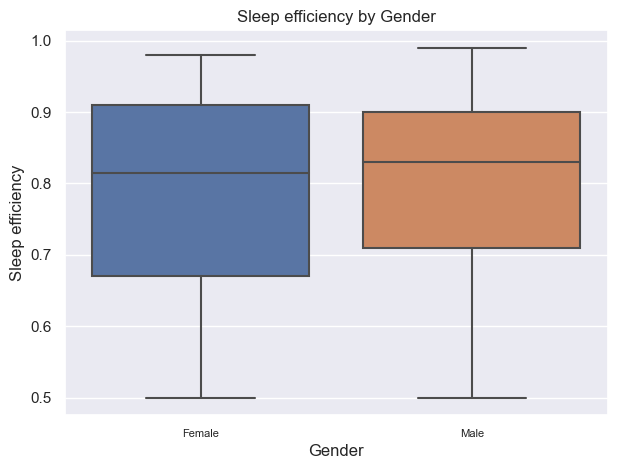

In [20]:
# create groupby for ordering x ticks by mean(ascending)
sort = df.groupby(["Gender"]).agg({'Sleep efficiency' : 'mean'}).sort_values(by='Sleep efficiency')

# boxplot
fig, ax = plt.subplots(figsize = (7,5))
vclass = sns.boxplot(x = "Gender", y = "Sleep efficiency", data = df, ax = ax, order = sort.index)
ax.set_title("Sleep efficiency by Gender")
ax.tick_params(axis='x', labelsize=8)
plt.show()

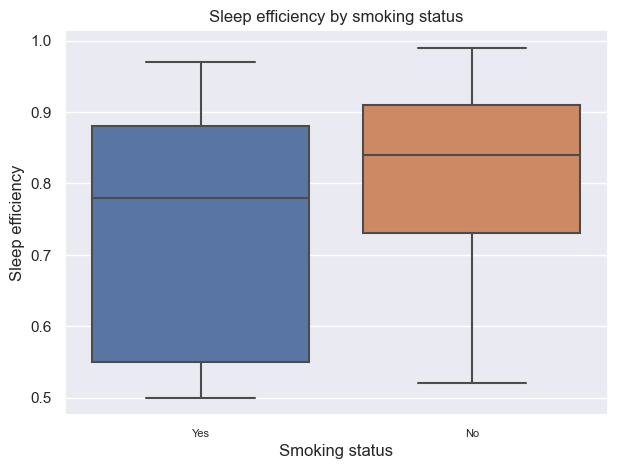

In [21]:
# create groupby for ordering x ticks by mean(ascending)
sort = df.groupby(["Smoking status"]).agg({'Sleep efficiency' : 'mean'}).sort_values(by='Sleep efficiency')

# boxplot
fig, ax = plt.subplots(figsize = (7,5))
vclass = sns.boxplot(x = "Smoking status", y = "Sleep efficiency", data = df, ax = ax, order = sort.index)
ax.set_title("Sleep efficiency by smoking status")
ax.tick_params(axis='x', labelsize=8)
plt.show()

In [22]:
df.groupby('Smoking status').mean()

,ID,Age,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Exercise frequency,Bed_hour,Wakeup_hour
Smoking status,,,,,,,,,,,,,
No,225.486577,39.989933,7.463087,0.817081,22.533557,55.372483,22.093960,1.630872,23.573826,1.053691,1.835570,12.184564,6.651007
Yes,228.461039,40.857143,7.470779,0.734416,22.772727,47.889610,29.337662,1.577922,24.025974,1.298701,1.714286,7.714286,7.376623


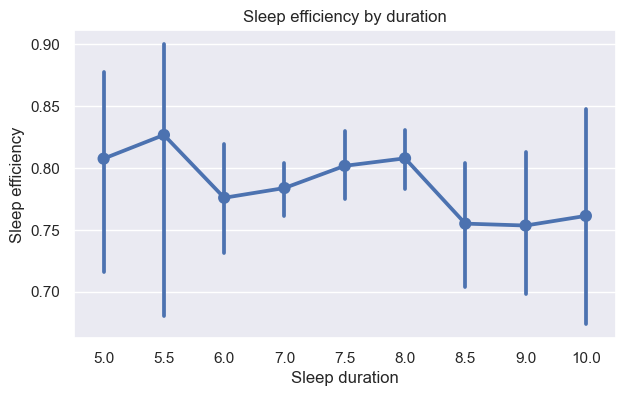

In [23]:
fig, ax = plt.subplots(figsize = (7,4))
sns.pointplot(y = 'Sleep efficiency', x = "Sleep duration", data = df, ax = ax)
ax.set_title("Sleep efficiency by duration")
plt.show()

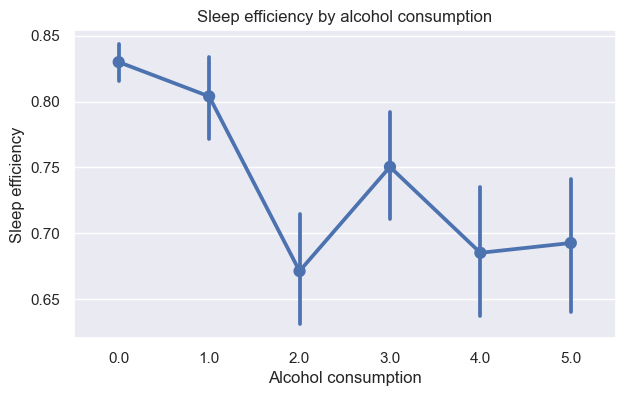

In [24]:
fig, ax = plt.subplots(figsize = (7,4))
sns.pointplot(y = 'Sleep efficiency', x = "Alcohol consumption", data = df, ax = ax)
ax.set_title("Sleep efficiency by alcohol consumption")
plt.show()

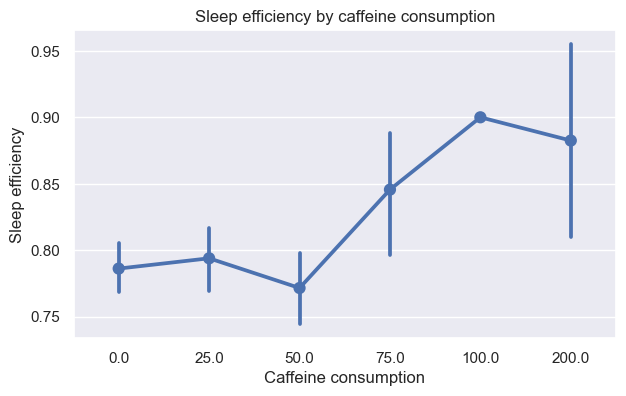

In [25]:
fig, ax = plt.subplots(figsize = (7,4))
sns.pointplot(y = 'Sleep efficiency', x = "Caffeine consumption", data = df, ax = ax)
ax.set_title("Sleep efficiency by caffeine consumption")
plt.show()

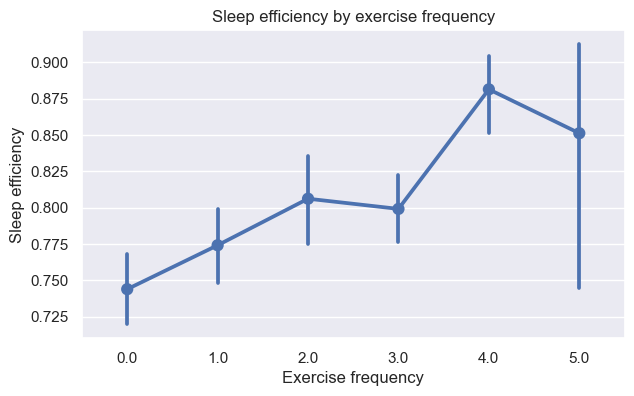

In [26]:
fig, ax = plt.subplots(figsize = (7,4))
sns.pointplot(y = 'Sleep efficiency', x = "Exercise frequency", data = df, ax = ax)
ax.set_title("Sleep efficiency by exercise frequency")
plt.show()

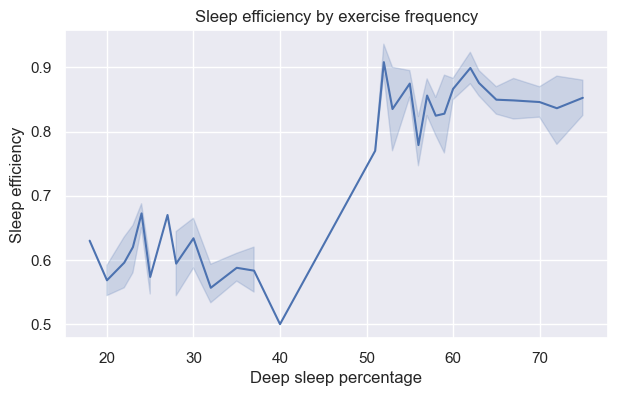

In [27]:
fig, ax = plt.subplots(figsize = (7,4))
sns.lineplot(y = 'Sleep efficiency', x = "Deep sleep percentage", data = df, ax = ax)
ax.set_title("Sleep efficiency by exercise frequency")
plt.show()

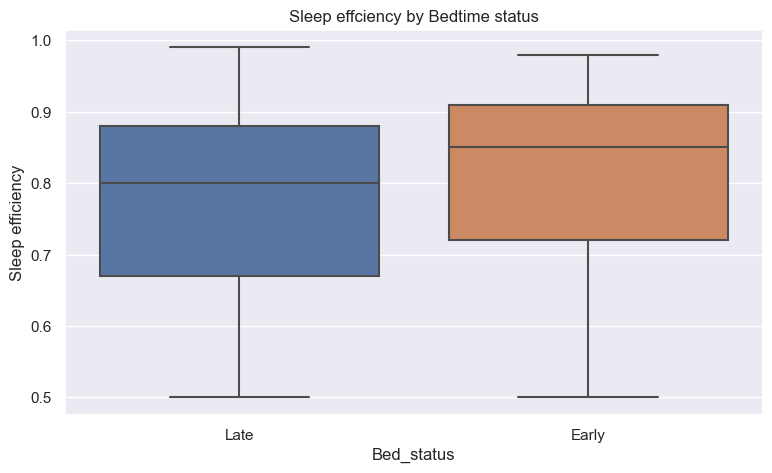

In [28]:
fig, ax = plt.subplots(figsize = (9,5))
sns.boxplot(y = "Sleep efficiency", x =  "Bed_status", data = df, ax = ax)
ax.set_title("Sleep effciency by Bedtime status")
plt.show()

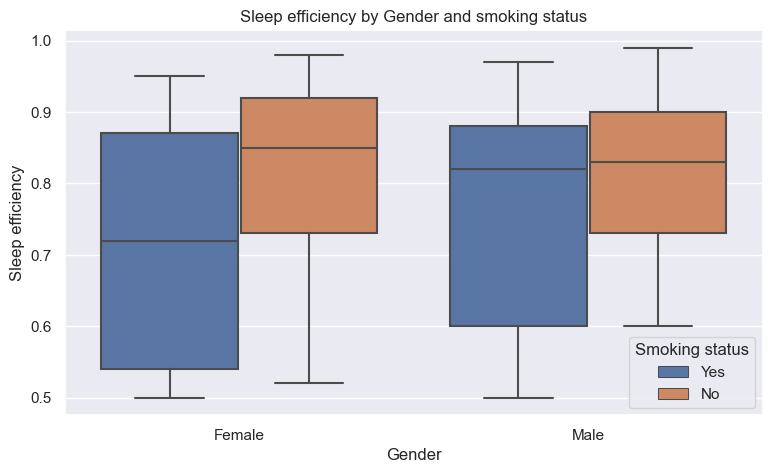

In [29]:
# Kode di bawah bertujuan untuk melihat distribusi dari botak_prob berdasarkan kategori jenis kelamin dan kategori status pernikahan dengan menggunakan boxplot.
fig, ax = plt.subplots(figsize = (9,5))
sns.boxplot(y = "Sleep efficiency", x =  "Gender",hue = 'Smoking status', data = df, ax = ax)
ax.set_title("Sleep efficiency by Gender and smoking status")
plt.show()

### **2. Statistical Test**

In [30]:
men = df[df["Gender"] == "Male"]["Sleep efficiency"] # Membuat variabel untuk kategori laki-laki.
women = df[df["Gender"] == "Female"]["Sleep efficiency"] # Membuat variabel untuk kategori perempuan.

n_men = men.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_women = women.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(men, women, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk laki-laki = {n_men}')
print(f'Banyak sampel untuk perempuan = {n_women}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_laki-laki - mu_perempuan <= 0')
print('H1 : mu_laki-laki - mu_perempuan > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Nilai p-value > 0.05 yang berarti tidak adanya perbedaan rata-rata sleep efficiency \
antara laki-laki dan perempuan secara signifikan.")
print("Gagal menolak H0 yang dimana tidak perbedaan rata-rata sleep efficiency \
yang signifikan antara laki-laki dan perempuan.")

Banyak sampel untuk laki-laki = 228
Banyak sampel untuk perempuan = 224
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_laki-laki - mu_perempuan <= 0
H1 : mu_laki-laki - mu_perempuan > 0
alpha = 0.05
Statistik Hitung = 0.21345098376080054
P Value = 0.41553594422909024
Kesimpulan :
Nilai p-value > 0.05 yang berarti tidak adanya perbedaan rata-rata sleep efficiency antara laki-laki dan perempuan secara signifikan.
Gagal menolak H0 yang dimana tidak perbedaan rata-rata sleep efficiency yang signifikan antara laki-laki dan perempuan.


In [31]:
smoker = df[df["Smoking status"] == "Yes"]["Sleep efficiency"] # Membuat variabel untuk kategori laki-laki.
non_smoker = df[df["Smoking status"] == "No"]["Sleep efficiency"] # Membuat variabel untuk kategori perempuan.

n_smoker = smoker.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_nonsmoker = non_smoker.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(smoker, non_smoker, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk smoker = {n_smoker}')
print(f'Banyak sampel untuk non-smoker = {n_nonsmoker}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_smoker - mu_nonsmoker <= 0')
print('H1 : mu_smoker - mu_nonsmoker > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Nilai p-value > 0.05 yang berartikan tidak adanya perbedaan rata-rata sleep efficiency \
antara smoker dan non-smoker secara signifikan.")
print("Gagal tolak H0 yang dimana tidak ada bukti kuat bahwa rata-rata sleep efficiency \
smoker lebih besar daripada non-smoker")

Banyak sampel untuk smoker = 154
Banyak sampel untuk non-smoker = 298
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_smoker - mu_nonsmoker <= 0
H1 : mu_smoker - mu_nonsmoker > 0
alpha = 0.05
Statistik Hitung = -6.4286893157053955
P Value = 0.9999999998355844
Kesimpulan :
Nilai p-value > 0.05 yang berartikan tidak adanya perbedaan rata-rata sleep efficiency antara smoker dan non-smoker secara signifikan.
Gagal tolak H0 yang dimana tidak ada bukti kuat bahwa rata-rata sleep efficiency smoker lebih besar daripada non-smoker


In [32]:
early = df[df["Bed_status"] == "Early"]["Sleep efficiency"] # Membuat variabel untuk kategori laki-laki.
late = df[df["Bed_status"] == "Late"]["Sleep efficiency"] # Membuat variabel untuk kategori perempuan.

n_early = early.shape[0] # Menghitung jumlah observasi pada kategori laki-laki.
n_late = late.shape[0] # Menghitung jumlah obsercasi pada kategori perempuan.
result = ttest_ind(early, late, equal_var = True, random_state = 42, alternative= 'greater') # melakukan Uji t.

print(f'Banyak sampel untuk Early = {n_smoker}')
print(f'Banyak sampel untuk Late = {n_nonsmoker}')
print('='*50)

print('Pertama, menyatakan hipotesis dan taraf signifikansi:')
print('H0 : mu_early - mu_late <= 0')
print('H1 : mu_early - mu_late > 0')
print("alpha = 0.05")
print("="*50)

print(f"Statistik Hitung = {result[0]}")
print(f"P Value = {result[1]}")
print("="*50)

print("Kesimpulan :")
print("Nilai p-value < 0.05 yang berarti adanya perbedaan rata-rata sleep efficiency \
antara seseorang yang tidur Early dan Late secara signifikan.")
print("Tolak H0, seseorang yang tidur Early memiliki rata-rata sleep efficiency \
yang lebih baik daripada tidur Late")

Banyak sampel untuk Early = 154
Banyak sampel untuk Late = 298
Pertama, menyatakan hipotesis dan taraf signifikansi:
H0 : mu_early - mu_late <= 0
H1 : mu_early - mu_late > 0
alpha = 0.05
Statistik Hitung = 2.7946246133372075
P Value = 0.0027090144359356214
Kesimpulan :
Nilai p-value < 0.05 yang berarti adanya perbedaan rata-rata sleep efficiency antara seseorang yang tidur Early dan Late secara signifikan.
Tolak H0, seseorang yang tidur Early memiliki rata-rata sleep efficiency yang lebih baik daripada tidur Late


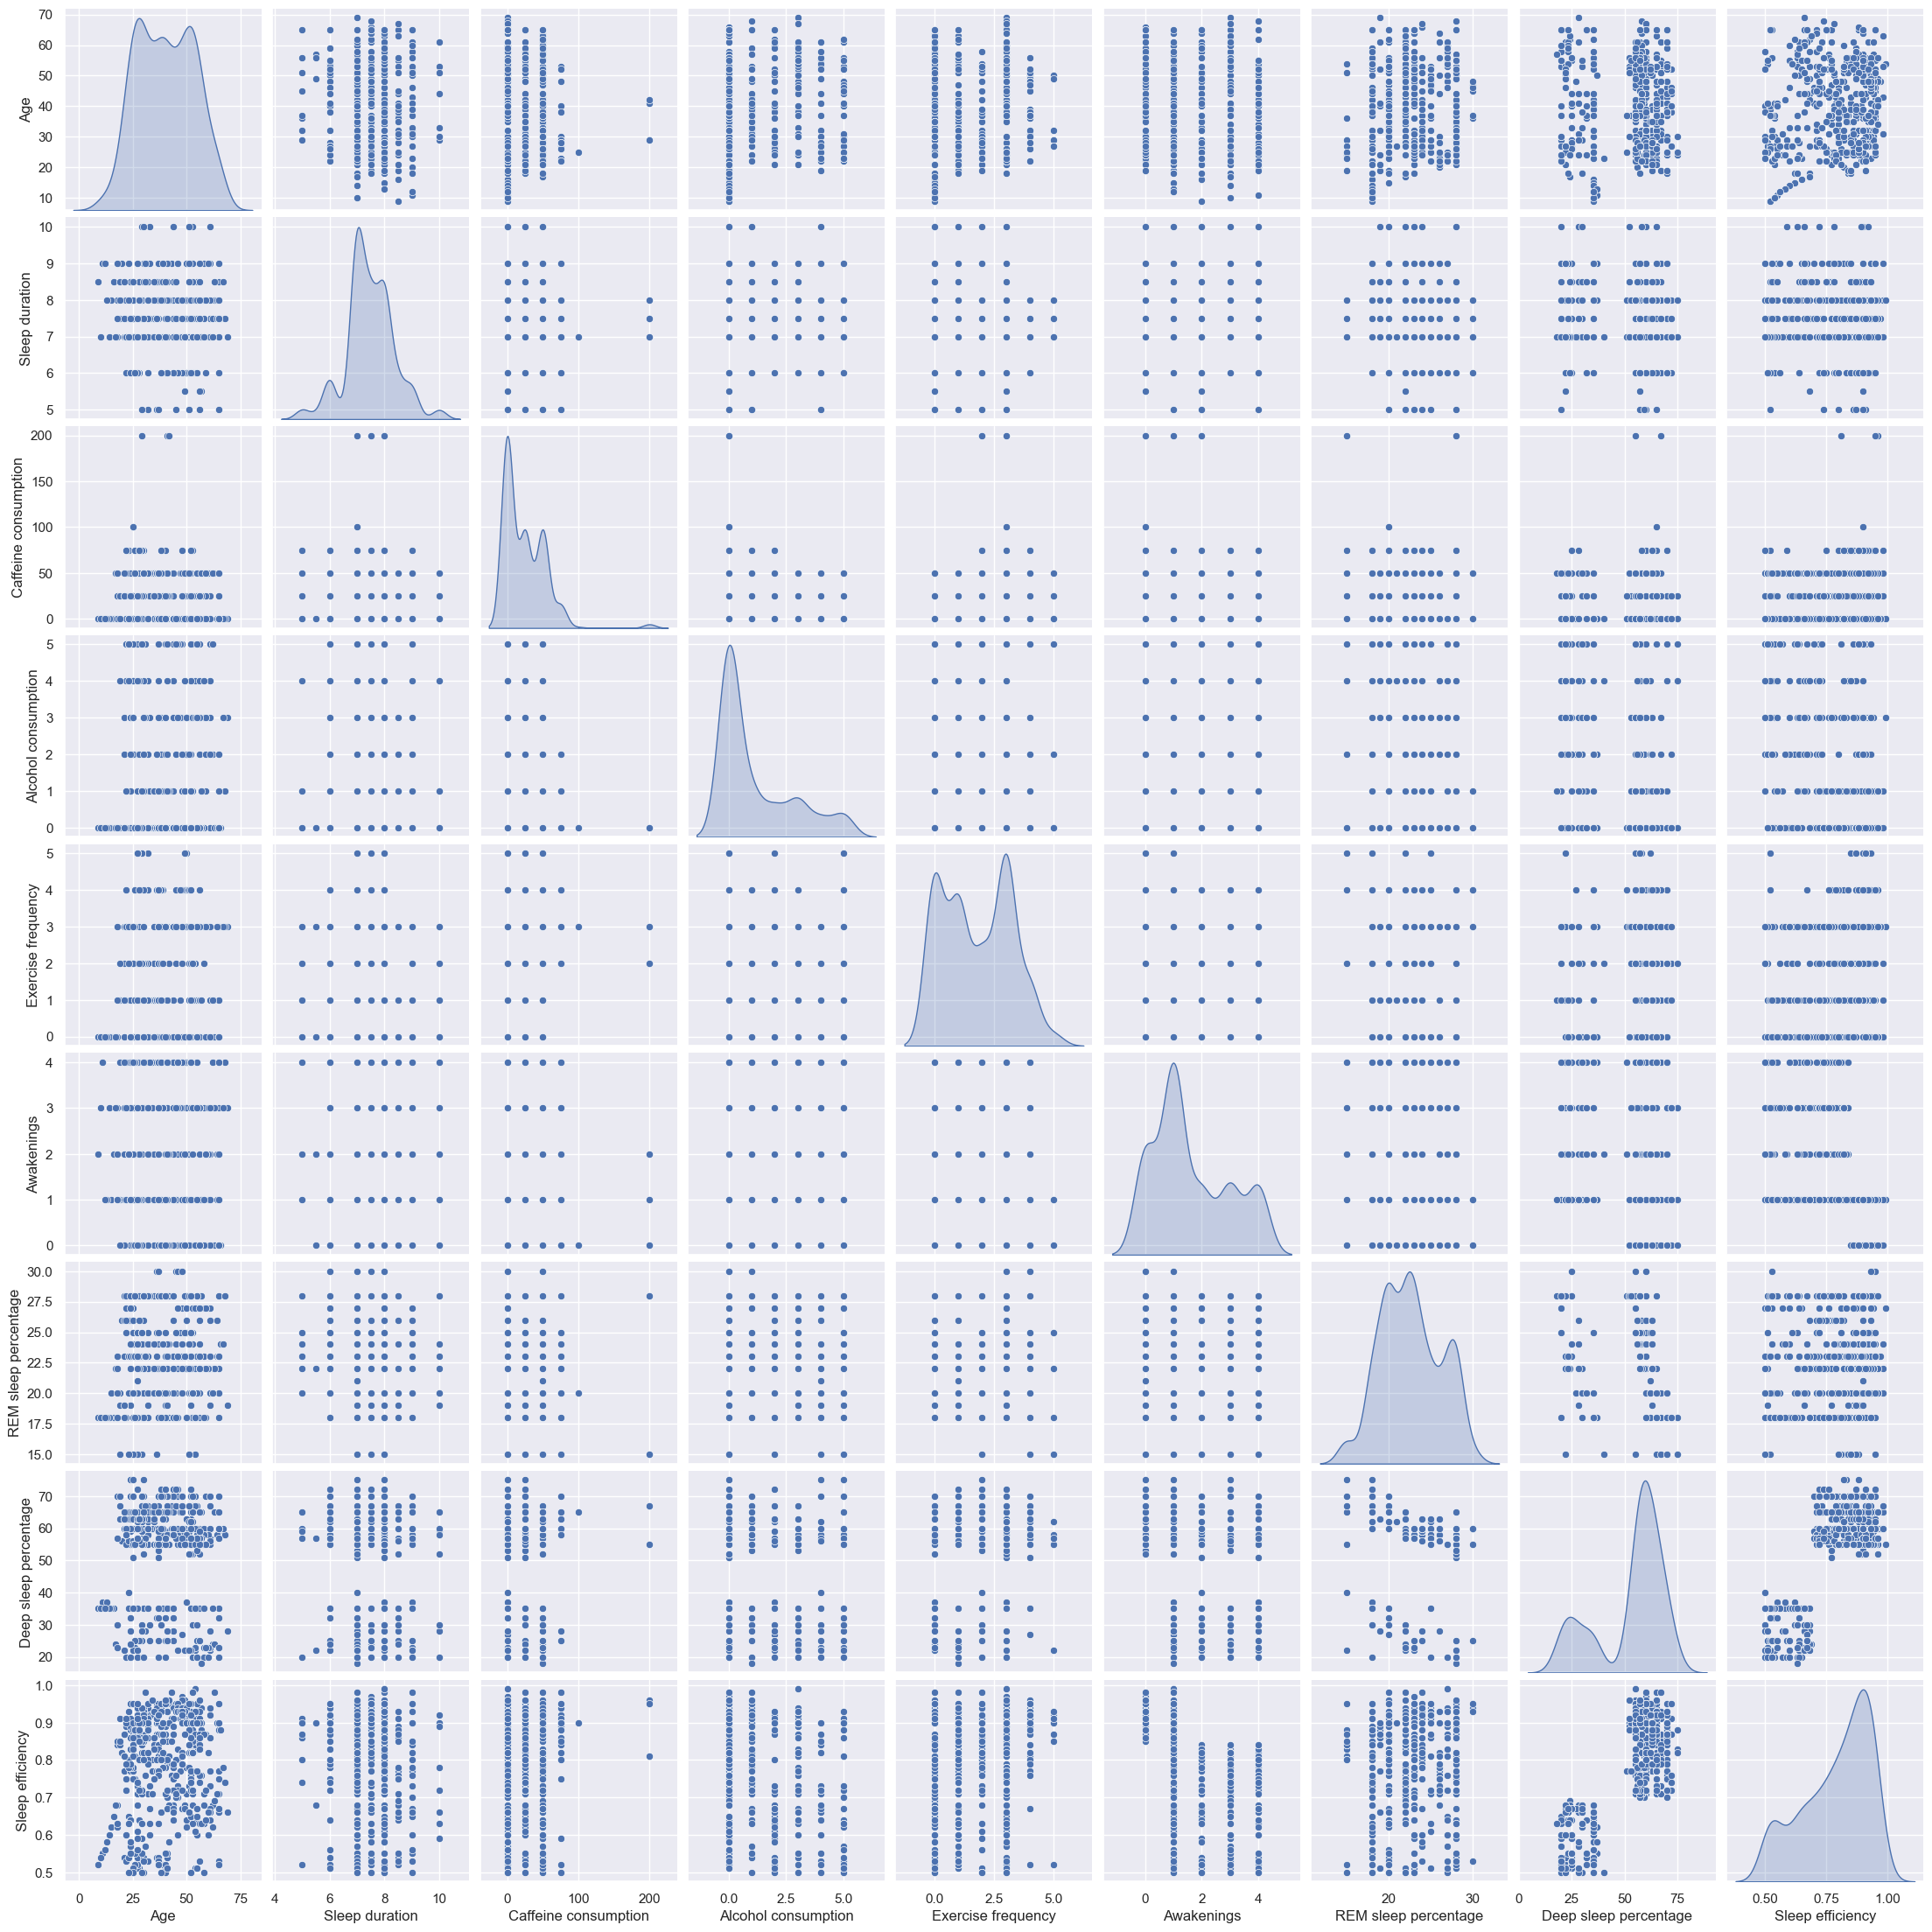

In [33]:
# Kode di bawah bertujuan untuk memvisualisasikan interaksi antara bebera features dengan meggunakan scatter plot dan kde plot.
columns_ = ["Age","Sleep duration","Caffeine consumption","Alcohol consumption","Exercise frequency","Awakenings","REM sleep percentage", "Deep sleep percentage","Sleep efficiency"]
sns.pairplot(df[columns_], diag_kind = 'kde')
plt.show()

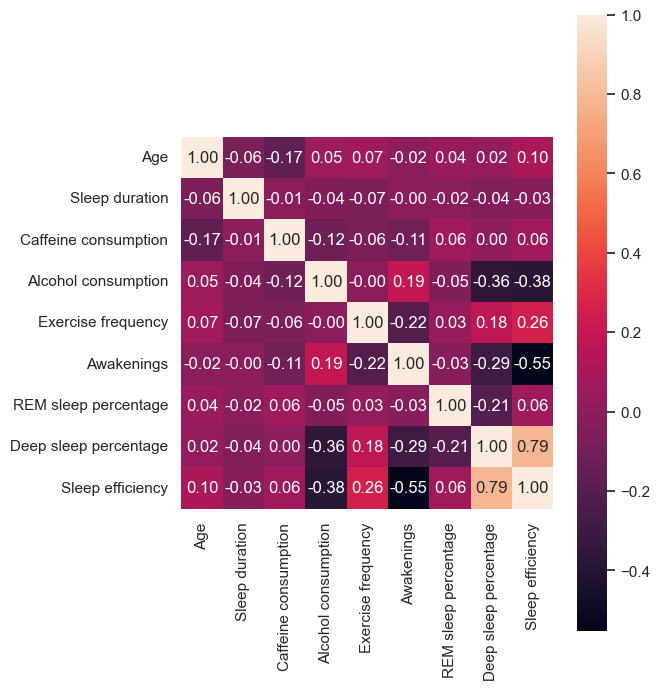

In [34]:
# Kode di bawah untuk melihat korelasi antar features.
corr_ = df[columns_].corr()
plt.figure(figsize = (6,8))
sns.heatmap(corr_, fmt= ".2f", annot= True,square= True)
plt.show()

Caffeine, REM sleep dan Age don't tidak punya korelasi kuat dengan Sleep efficiency

### **3. Building Regression Models**

In [35]:
# Drop variables with very weak correlations to sleep efficiency according to heatmap
df.drop(['Caffeine consumption','REM sleep percentage', 'Age'], axis=1, inplace = True)
df.head()

,ID,Gender,Sleep duration,Sleep efficiency,Deep sleep percentage,Light sleep percentage,Awakenings,Alcohol consumption,Smoking status,Exercise frequency,Bed_hour,Wakeup_hour,Bed_status
0,1,Female,6.000000,0.880000,70,12,0.000000,0.000000,Yes,3.000000,1,7,Late
1,2,Male,7.000000,0.660000,28,53,3.000000,3.000000,Yes,3.000000,2,9,Late
2,3,Female,8.000000,0.890000,70,10,1.000000,0.000000,No,3.000000,21,5,Early
3,4,Female,6.000000,0.510000,25,52,3.000000,5.000000,Yes,1.000000,2,8,Late
4,5,Male,8.000000,0.760000,55,18,3.000000,3.000000,No,3.000000,1,9,Late


**3.1 Single Predictor**

In [36]:
#Construct the model
lm = smf.ols('Q("Sleep efficiency") ~ Q("Gender")', data = df).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("Sleep efficiency")   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.002
Method:                    Least Squares   F-statistic:                   0.04556
Date:                   Mon, 03 Jul 2023   Prob (F-statistic):              0.831
Time:                           22:56:53   Log-Likelihood:                 263.49
No. Observations:                    452   AIC:                            -523.0
Df Residuals:                        450   BIC:                            -514.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

**3.2 Multiple Predictor**

Membuat Class untuk evaluasi model

In [37]:
class StatsmodelsRegressor(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    
    def __init__(self, sm_class, sm_formula):
        self.sm_class = sm_class
        self.sm_formula = sm_formula
        self.model = None
        self.result = None
 
    def fit(self, data, dummy):
        self.model = self.sm_class(self.sm_formula, data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

def kfold_split(data, n_fold):
    """
    Function to combine estimated coefficients and standard error in one DataFrame
    :param data: <pandas DataFrame> 
    :param n_fold: <int> Number of fold in k-fold CV
    :return fold_train: <pandas DataFrame> Training Data
    :return fold_test: <pandas DataFrame> Testing Data
    """
    kfold = KFold(n_splits = n_fold, 
                  shuffle = True, 
                  random_state=123)
    fold_train = {}
    fold_test = {}

    for i, (train, test) in enumerate(kfold.split(data)):
        print(f"fold {i+1}, train data rows: {len(train)}, test data rows: {len(test)}")
        fold_train[i] = data.iloc[train].copy()
        fold_test[i] = data.iloc[test].copy()
        
    return (fold_train, fold_test)

Model with all variables

In [38]:
#Construct the model
lm = smf.ols('Q("Sleep efficiency") ~ Q("Gender") + Q("Smoking status") + Q("Sleep duration") + Bed_status\
                                   + Q("Deep sleep percentage") + Q("Awakenings") + Q("Alcohol consumption")\
                                    + Q("Exercise frequency")', data = df).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("Sleep efficiency")   R-squared:                       0.764
Model:                               OLS   Adj. R-squared:                  0.760
Method:                    Least Squares   F-statistic:                     179.5
Date:                   Mon, 03 Jul 2023   Prob (F-statistic):          8.30e-134
Time:                           22:56:53   Log-Likelihood:                 590.03
No. Observations:                    452   AIC:                            -1162.
Df Residuals:                        443   BIC:                            -1125.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

One hot encoding

In [39]:
#One hot encoding for categorical variables
encoded_df = pd.get_dummies(data = df, columns = ['Gender', 'Smoking status','Bed_status'])
encoded_df.head()

,ID,Sleep duration,Sleep efficiency,Deep sleep percentage,Light sleep percentage,Awakenings,Alcohol consumption,Exercise frequency,Bed_hour,Wakeup_hour,Gender_Female,Gender_Male,Smoking status_No,Smoking status_Yes,Bed_status_Early,Bed_status_Late
0,1,6.000000,0.880000,70,12,0.000000,0.000000,3.000000,1,7,1,0,0,1,0,1
1,2,7.000000,0.660000,28,53,3.000000,3.000000,3.000000,2,9,0,1,0,1,0,1
2,3,8.000000,0.890000,70,10,1.000000,0.000000,3.000000,21,5,1,0,1,0,1,0
3,4,6.000000,0.510000,25,52,3.000000,5.000000,1.000000,2,8,1,0,0,1,0,1
4,5,8.000000,0.760000,55,18,3.000000,3.000000,3.000000,1,9,0,1,1,0,0,1


Model with encoded categorical variables

In [40]:
#Construct the model
lm = smf.ols('Q("Sleep efficiency") ~ Q("Gender_Male") + Q("Gender_Female") + Q("Smoking status_No") + Q("Smoking status_Yes") + Q("Sleep duration") + Bed_status_Early + Bed_status_Late \
                                   + Q("Deep sleep percentage")+ Q("Awakenings") + Q("Alcohol consumption")\
                                    + Q("Exercise frequency")', data = encoded_df).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("Sleep efficiency")   R-squared:                       0.764
Model:                               OLS   Adj. R-squared:                  0.760
Method:                    Least Squares   F-statistic:                     179.5
Date:                   Mon, 03 Jul 2023   Prob (F-statistic):          8.30e-134
Time:                           22:56:53   Log-Likelihood:                 590.03
No. Observations:                    452   AIC:                            -1162.
Df Residuals:                        443   BIC:                            -1125.
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Terlihat bahwa variabel gender dan smoking status signifikan di pemodelan, walaupun kedua variabel ini tidak signifikan saat Uji statistik

In [41]:
# Drop Gender and Smoking status variables
encoded_df.drop(['Gender_Male','Gender_Female', 'Smoking status_No','Smoking status_Yes'], axis=1, inplace = True)

Model after dropping Gender and Smoking Status:

In [42]:
#Construct the model
lm = smf.ols('Q("Sleep efficiency") ~ Q("Sleep duration") + Bed_status_Early + Bed_status_Late \
                                   + Q("Deep sleep percentage")+ Q("Awakenings") + Q("Alcohol consumption")\
                                    + Q("Exercise frequency")', data = encoded_df).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("Sleep efficiency")   R-squared:                       0.743
Model:                               OLS   Adj. R-squared:                  0.739
Method:                    Least Squares   F-statistic:                     214.2
Date:                   Mon, 03 Jul 2023   Prob (F-statistic):          8.46e-128
Time:                           22:56:53   Log-Likelihood:                 570.36
No. Observations:                    452   AIC:                            -1127.
Df Residuals:                        445   BIC:                            -1098.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

In [43]:
# Drop insignificant variables (p value > 0.05)
encoded_df.drop(['Sleep duration'], axis=1, inplace = True)

Model after dropping insignificant variables (Sleep duration)

In [44]:
#Construct the model
lm = smf.ols('Q("Sleep efficiency") ~ Bed_status_Early + Bed_status_Late \
                                   + Q("Deep sleep percentage")+ Q("Awakenings") + Q("Alcohol consumption") + Q("Exercise frequency")\
                                    ', data = encoded_df).fit()
print(lm.summary())

                              OLS Regression Results                             
Dep. Variable:     Q("Sleep efficiency")   R-squared:                       0.743
Model:                               OLS   Adj. R-squared:                  0.740
Method:                    Least Squares   F-statistic:                     257.6
Date:                   Mon, 03 Jul 2023   Prob (F-statistic):          5.02e-129
Time:                           22:56:53   Log-Likelihood:                 570.35
No. Observations:                    452   AIC:                            -1129.
Df Residuals:                        446   BIC:                            -1104.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

Model dapat dinotasikan sebagai persamaan berikut:

$$\text{Sleep Efficiency} = 0.3635 + 0.1830\text{ Bed Early} + 0.1804\text{ Bed Late} + 0.0056\text{ Deep sleep} - 0.0335\text{ Awakenings} - 0.0074\text{ Alcohol consumption} + 0.0064\text{ Exercise frequency}

Sleep Efficiency, if Bed early:

$$\text{Sleep Efficiency} = 0.3635 + 0.1830 + 0.0056\text{ Deep sleep} - 0.0335\text{ Awakenings} - 0.0074\text{ Alcohol consumption} + 0.0064\text{ Exercise frequency}

Sleep Efficiency, if Bed Late:

$$\text{Sleep Efficiency} = 0.5439 + 0.1804 + 0.0056\text{ Deep sleep} - 0.0335\text{ Awakenings} - 0.0074\text{ Alcohol consumption} + 0.0064\text{ Exercise frequency}

In [1]:
plt.scatter(lm.fittedvalues, lm.resid, marker=".", c = "k")

# Plot the horizontal line in 0 as the fitted line
plt.axhline([0])

plt.xlabel("Sleep efficiency")
plt.ylabel("residual")
plt.title(f"Residuals vs. sleep efficiency")

NameError: name 'plt' is not defined

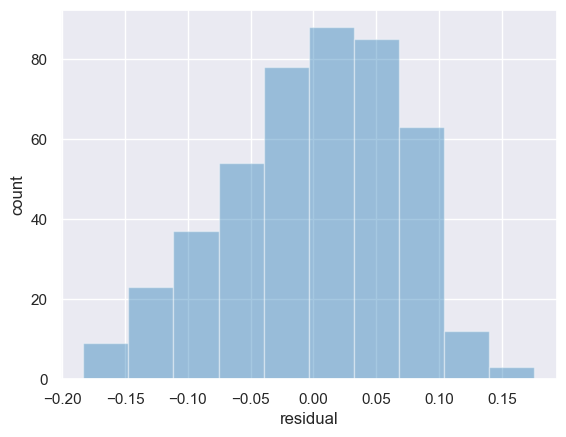

In [46]:
plt.hist(lm.resid, color='tab:blue', alpha=0.4)
plt.xlabel("residual")
plt.ylabel("count")

plt.show()

Model evaluation

In [47]:
# Create a class model
ols_all_var = StatsmodelsRegressor(smf.ols, 'Q("Sleep efficiency") ~ Q("Bed_status_Early") + Q("Bed_status_Late")\
                                   + Q("Deep sleep percentage")+ Q("Awakenings") + Q("Alcohol consumption")\
                                    + Q("Exercise frequency")')

# Create k-fold splitter objects
kfold = KFold(n_splits=5, shuffle = True, random_state=123)

scores_ols_all_var = cross_val_score(estimator = ols_all_var,
                                       X = encoded_df,
                                       y = encoded_df["Sleep efficiency"],
                                       cv = kfold,
                                       scoring = "r2")
scores_ols_all_var = pd.DataFrame(data = scores_ols_all_var, 
                                    columns=["test_rsquared"])
scores_ols_all_var["folds"] = [f"Folds {i+1}" for i in range(5)]
scores_ols_all_var

,test_rsquared,folds
0,0.775182,Folds 1
1,0.681150,Folds 2
2,0.757691,Folds 3
3,0.687398,Folds 4
4,0.765273,Folds 5


In [48]:
# Hasil evaluasi
scores_ols_all_var["test_rsquared"].mean()

0.7333388625636614